In [3]:
#run = os.environ.get('run')
run ='waom10'

#gauss_smooth = 10

T_mask_path = os.path.join(os.environ.get('extdir'),'tamura','EASE_landmask_H.data')
T_lat_lon_path = os.path.join(os.environ.get('extdir'),'tamura','latlon.data')
era_path = os.path.join(os.environ.get('extdir'),'era_interim','ERA_Interim_1992_2011.2daily.*winds.nc')

#out_dir = os.path('/home/ubuntu/raijin/g/data2/gh9/oxr581/waom1_frc')
out_dir = os.environ.get('intdir')

In [2]:
import numpy as np 
import os
import sys
import xarray as xr
import scipy.io as sio
import matplotlib.pyplot as plt
import datetime

from dotenv import load_dotenv, find_dotenv

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
src_dir = os.environ.get('srcdir')
sys.path.append(src_dir)

# always reload modules marked with "%aimport"
%load_ext autoreload
%autoreload 1

from features.grid_ttide import NDinterp
from features.log_progress import log_progress
from scipy.ndimage.filters import gaussian_filter

In [41]:

R_grid_path = os.path.join(os.environ.get('prodir'),run+'_grd.nc')
R_grid = xr.open_dataset(R_grid_path)
R_lon = R_grid.lon_rho.values
R_lat = R_grid.lat_rho.values
R_angle = R_grid.angle.values
R_ulon = R_grid.lon_u.values
R_vlon = R_grid.lon_v.values
R_ulat = R_grid.lat_u.values
R_vlat = R_grid.lat_v.values


R_lon[R_lon<0]+=360
R_ulon[R_ulon<0]+=360
R_vlon[R_vlon<0]+=360

In [4]:
#read in tamura land mask

with open(T_mask_path,'rb') as fid:
    T_mask = np.fromfile(fid,count=(721*721),dtype='float32').reshape((721,721))
    T_mask = np.flipud(T_mask)

In [15]:
#get tamura lat lon coordinates

with open(T_lat_lon_path,'rb') as fid:
    T_lat_lon = np.fromfile(fid,count=(721*721*2),dtype='float32').reshape((2,721,721))
T_lat,T_lon = (T_lat_lon[0],T_lat_lon[1])
T_lat = np.flipud(T_lat)
T_lon = np.flipud(T_lon)
T_lon[T_lon<0]+=360

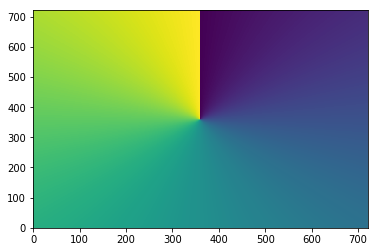

In [16]:
plt.close()
plt.pcolormesh(T_lon)
plt.show()

In [25]:
month = 'jan'
Tidx = 0
days = 31
T_data_path = os.path.join(os.environ.get('extdir'),'tamura','TSDM2hb_2007_'+month+'.data')
with open(T_data_path,'rb') as fid:
    T_data = np.swapaxes(np.fromfile(fid,count = days*6*721*721 ,dtype='float32').reshape(days,6,721,721),0,1)

#looping over the days with running day-of-the-year and day-of-the-month index
#for Eidx,Tidx in zip(log_progress(daysOfYear-1,name='days'),np.arange(days)):

    #read in Tamura heat and fresh water flux and turn in right position
    shflux_tmp = np.flipud(T_data[0,Tidx])
    ssflux_tmp = np.flipud(T_data[2,Tidx])

    #fill in tamuar mask for later resampling
    shflux_tmp[T_mask==0] = np.nan
    shflux_tmp = NDinterp(shflux_tmp)

    ssflux_tmp[T_mask==0] = np.nan
    ssflux_tmp = NDinterp(ssflux_tmp)

In [28]:
T_dat = shflux_tmp
ilon = T_lon[T_lat<R_lat.max()]
ilat = T_lat[T_lat<R_lat.max()]
idat = T_dat[T_lat<R_lat.max()]

from scipy.interpolate import griddata

out_nearest = griddata((ilon,ilat),idat,(R_lon,R_lat),'nearest')
out_linear = griddata((ilon,ilat),idat,(R_lon,R_lat),'linear')
out_cubic =griddata((ilon,ilat),idat,(R_lon,R_lat),'cubic')

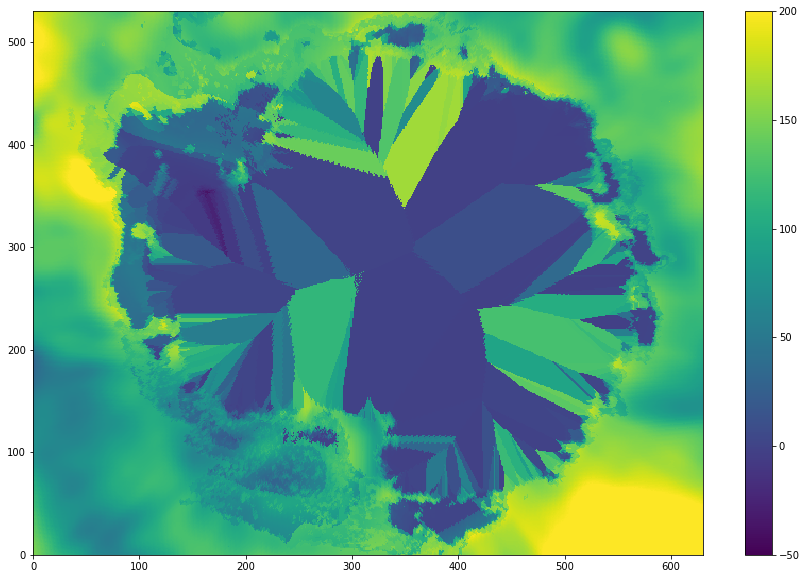

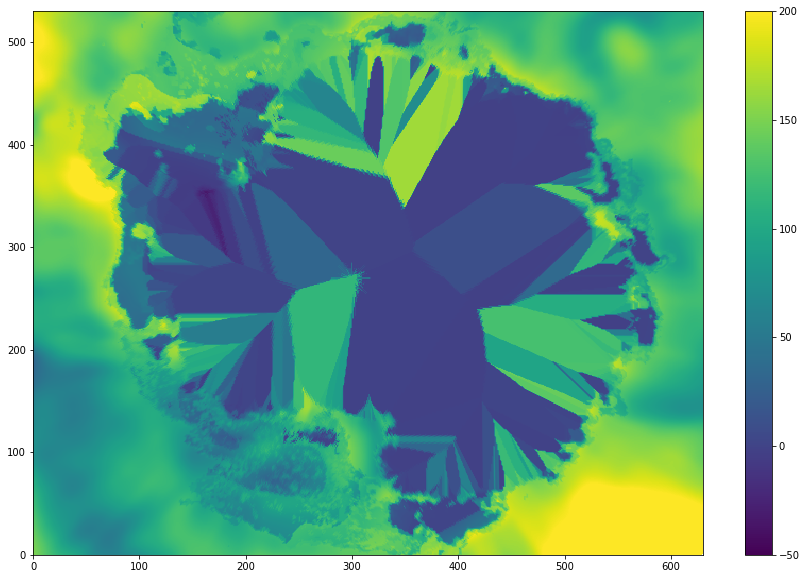

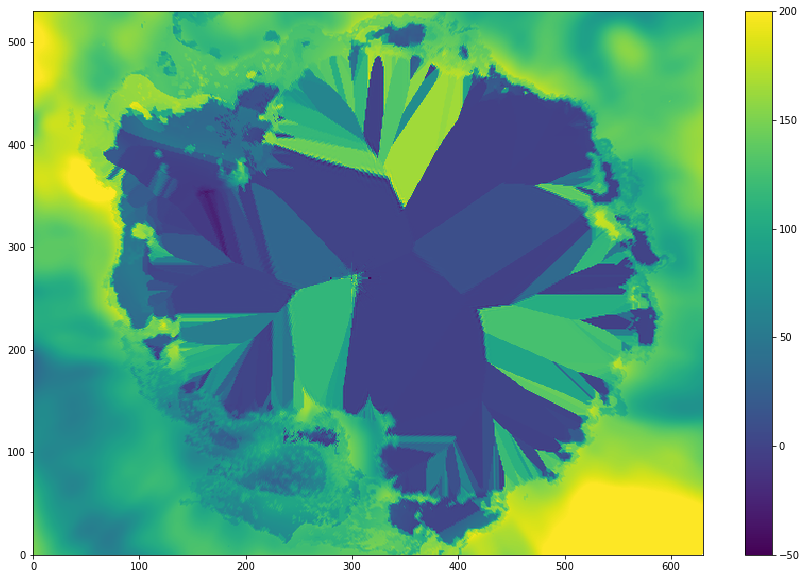

In [31]:
plt.close()
for out in [out_nearest,out_linear,out_cubic]:
    plt.figure(figsize=(15,10))
    plt.pcolormesh(out,vmin=-50,vmax=200)
    plt.colorbar()
    plt.show()

In [6]:
#read in era interim winds and resample from twice daily to daily

era_ds = xr.open_mfdataset(era_path,data_vars='minimal').sel(time='2007',latitude=slice(-30,-90)).resample(time='D').mean()

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


In [9]:
#get era coordinates
era_lon_raw,era_lat_raw = era_ds.longitude.values,era_ds.latitude.values
era_lon = np.zeros(np.size(era_lon_raw)+2)
era_lon[0] = era_lon_raw[-1]-360
era_lon[1:-1] = era_lon_raw[:]
era_lon[-1] = era_lon_raw[0]+360

era_lon, era_lat = np.meshgrid(era_lon,era_lat_raw)

In [19]:
era_dat_raw = era_ds.u10[0].values
era_dat = np.zeros((np.size(era_dat_raw,0),np.size(era_dat_raw,1)+2))
era_dat[:,0] = era_dat_raw[:,-1]
era_dat[:,1:-1] = era_dat_raw[:,:]
era_dat[:,-1] = era_dat_raw[:,0]
era_dat.shape

(41, 242)

In [21]:
ilon = era_lon[era_lat<R_lat.max()]
ilat = era_lat[era_lat<R_lat.max()]
idat = era_dat[era_lat<R_lat.max()]

from scipy.interpolate import griddata

out_nearest = griddata((ilon,ilat),idat,(R_lon,R_lat),'nearest')
out_linear = griddata((ilon,ilat),idat,(R_lon,R_lat),'linear')
out_cubic =griddata((ilon,ilat),idat,(R_lon,R_lat),'cubic')

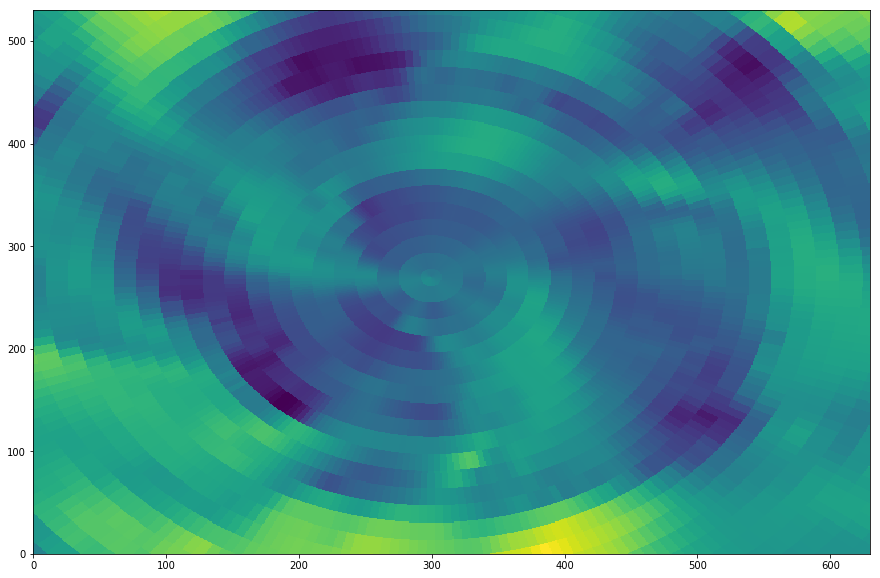

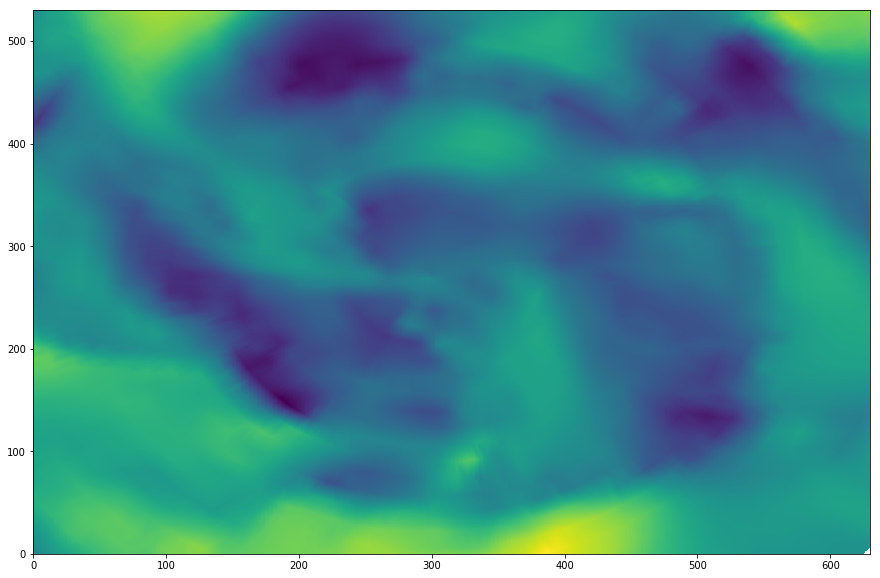

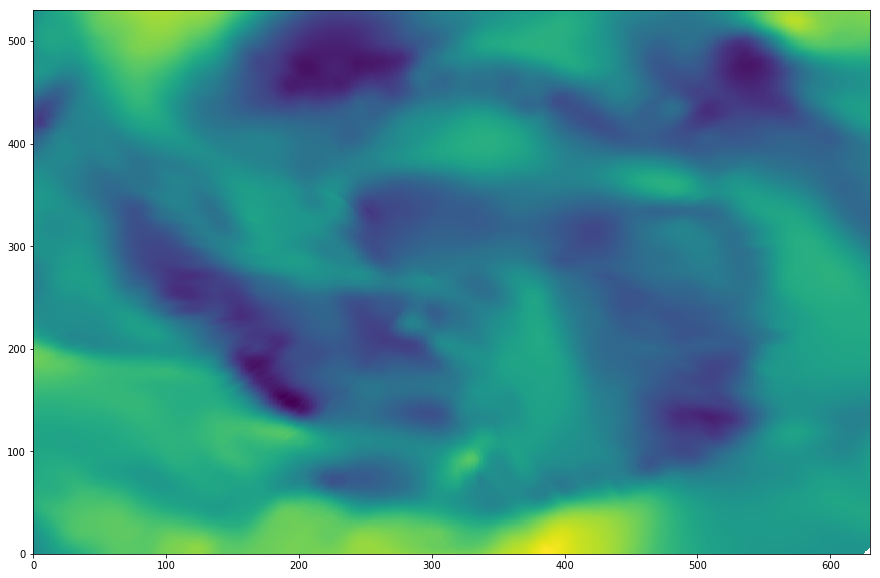

In [22]:
plt.close()
for out in [out_nearest,out_linear,out_cubic]:
    plt.figure(figsize=(15,10))
    plt.pcolormesh(out)
    plt.show()

In [119]:
from scipy.interpolate import NearestNDInterpolator

def NDinterp(data):

    valid_mask = ~np.isnan(data)
    coords = np.array(np.nonzero(valid_mask)).T
    values = data[valid_mask]

    it = NearestNDInterpolator(coords,values)

    filled = it(list(np.ndindex(data.shape))).reshape(data.shape)

    return filled

In [120]:
from pyresample import kd_tree, geometry, utils

E_lon, E_lat = utils.check_and_wrap(E_lon,E_lat)
T_lon, T_lat = utils.check_and_wrap(T_lon,T_lat)

T_def = geometry.SwathDefinition(lons=T_lon,lats=T_lat)
E_def = geometry.SwathDefinition(lons=E_lon,lats=E_lat)
R_def = geometry.SwathDefinition(lons=R_lon,lats=R_lat)
RV_def = geometry.SwathDefinition(lons=R_vlon,lats=R_vlat)
RU_def = geometry.SwathDefinition(lons=R_ulon,lats=R_ulat)

valid_input_index_T2R, valid_output_index_T2R, index_array_T2R, distance_array_T2R = \
kd_tree.get_neighbour_info(T_def,R_def, 10000,neighbours=4,nprocs=16)

wf_T2R = lambda r: 1/r

valid_input_index_E2RU, valid_output_index_E2RU, index_array_E2RU, distance_array_E2RU = \
kd_tree.get_neighbour_info(E_def,RU_def, 500000,neighbours=32,nprocs=16)

valid_input_index_E2RV, valid_output_index_E2RV, index_array_E2RV, distance_array_E2RV = \
kd_tree.get_neighbour_info(E_def,RV_def, 500000,neighbours=32,nprocs=16)

sigma = 250000
#wf_E2R = lambda r: 1/r
wf_E2R = lambda r: np.exp(-r**2/sigma**2)

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/pyresample/kd_tree.py:399: UserWarning: Possible more than 4 neighbours within 10000 m for some data points
  (neighbours, radius_of_influence))
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/pyresample/kd_tree.py:399: UserWarning: Possible more than 32 neighbours within 500000 m for some data points
  (neighbours, radius_of_influence))


In [37]:
from scipy.interpolate import griddata

def regrid_tamura(slon,slat,sdat,tlon,tlat):
    slon = slon[slat<tlat.max()]
    sdat = sdat[slat<tlat.max()]
    slat = slat[slat<tlat.max()]

    tdat =griddata((slon,slat),sdat,(tlon,tlat),'cubic')
        
    return tdat

In [38]:
def regrid_era(slon,slat,sdat_raw,tlon,tlat):
    
    sdat = np.zeros((np.size(sdat_raw,0),np.size(sdat_raw,1)+2))
    sdat[:,0] = sdat_raw[:,-1]
    sdat[:,1:-1] = sdat_raw[:,:]
    sdat[:,-1] = sdat_raw[:,0]
    
    slon = slon[slat<tlat.max()]
    sdat = sdat[slat<tlat.max()]
    slat = slat[slat<tlat.max()]

    tdat =griddata((slon,slat),sdat,(tlon,tlat),'cubic')
        
    return tdat

In [42]:
month = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
month_nb = ['01','02','03','04','05','06','07','08','09','10','11','12']
daysPerMonth = [31,28,31,30,31,30,31,31,30,31,30,31]

#month = ['nov']
#month_nb = ['11']
#daysPerMonth = [30]

#month = ['jan']
#
#daysPerMonth = [1]

dayOfYear = 1

for month,days,month_nb in zip(month,daysPerMonth,month_nb):
    
    print('Processing month: ',month,'with days: ',days)
    
    daysOfYear = np.arange(dayOfYear,dayOfYear+days,dtype=int)
    
    print('Containing days of year: ',daysOfYear)

    # preparing empty dataset
    ds = xr.Dataset({'shflux':(['shf_time','eta_rho','xi_rho'], np.empty((days,R_grid.eta_rho.size,R_grid.xi_rho.size))),
                     'swflux':(['swf_time','eta_rho','xi_rho'], np.empty((days,R_grid.eta_rho.size,R_grid.xi_rho.size))),
                     'sustr':(['sms_time','eta_u','xi_u'], np.empty((days,R_grid.eta_u.size,R_grid.xi_u.size))),
                     'svstr':(['sms_time','eta_v','xi_v'], np.empty((days,R_grid.eta_v.size,R_grid.xi_v.size)))},
                   coords={'shf_time':(['shf_time'],daysOfYear),
                           'swf_time':(['swf_time'],daysOfYear),
                           'sms_time':(['sms_time'],daysOfYear)})
   
    #open Tamura month flux data 
    T_data_path = os.path.join(os.environ.get('extdir'),'tamura','TSDM2hb_2007_'+month+'.data')
    with open(T_data_path,'rb') as fid:
        T_data = np.swapaxes(np.fromfile(fid,count = days*6*721*721 ,dtype='float32').reshape(days,6,721,721),0,1)
    
    #looping over the days with running day-of-the-year and day-of-the-month index
    for Eidx,Tidx in zip(log_progress(daysOfYear-1,name='days'),np.arange(days)):
        
        #read in Tamura heat and fresh water flux and turn in right position
        shflux_tmp = np.flipud(T_data[0,Tidx])
        ssflux_tmp = np.flipud(T_data[2,Tidx])
        
        #fill in tamuar mask for later resampling
        shflux_tmp[T_mask==0] = np.nan
        shflux_tmp = NDinterp(shflux_tmp)
        
        ssflux_tmp[T_mask==0] = np.nan
        ssflux_tmp = NDinterp(ssflux_tmp)
        
        shflux_tmp = regrid_tamura(T_lon,T_lat,shflux_tmp,R_lon,R_lat) 
        ssflux_tmp = regrid_tamura(T_lon,T_lat,ssflux_tmp,R_lon,R_lat)
        #resample to roms grid points
        #shflux_tmp = kd_tree.get_sample_from_neighbour_info('custom', R_def.shape, shflux_tmp,\
        #                                     valid_input_index_T2R,\
        #                                     valid_output_index_T2R,index_array_T2R,distance_array_T2R,wf_T2R)

        #ssflux_tmp = kd_tree.get_sample_from_neighbour_info('custom', R_def.shape, ssflux_tmp,\
        #                                     valid_input_index_T2R,\
        #                                     valid_output_index_T2R,index_array_T2R,distance_array_T2R,wf_T2R)
        
        #correct large summer heat flux values and save to dataset
        shflux_tmp[shflux_tmp > 0.0]*=0.5
        
        ds.shflux[Tidx] = shflux_tmp
        del shflux_tmp
        
        #convert to freshwater flux with convention positive up 'swf (E-P)',
        #that means a positive freshwater flux value results in positive salt flux value
        #and save to dataset
        refSalt = 34.4

        ds.swflux[Tidx] = ssflux_tmp/refSalt*100
        del ssflux_tmp
        
        #select era-interim winds
        uwnd = era_ds.u10[Eidx].values
        vwnd = era_ds.v10[Eidx].values
        
        #rotate wind directions to roms grid
        uv = (uwnd+1j*vwnd)*np.exp(1j*-(era_lon[:,1:-1]/180*np.pi))
        uwnd = uv.real
        vwnd = uv.imag
        
        
        uwnd = regrid_era(era_lon,era_lat,uwnd,R_ulon,R_ulat)
        vwnd = regrid_era(era_lon,era_lat,vwnd,R_vlon,R_vlat)
        #resample to roms u and v grid and save to dataset
        #uwnd = kd_tree.get_sample_from_neighbour_info('custom', RU_def.shape, uwnd,\
        #                                     valid_input_index_E2RU,\
        #                                     valid_output_index_E2RU,index_array_E2RU,
        #                                              distance_array_E2RU,wf_E2R,fill_value=None)
        
        #vwnd = kd_tree.get_sample_from_neighbour_info('custom', RV_def.shape, vwnd,\
        #                                     valid_input_index_E2RV,\
        #                                     valid_output_index_E2RV,index_array_E2RV,
        #                                              distance_array_E2RV,wf_E2R,fill_value=None)
        
        #uwnd = kd_tree.get_sample_from_neighbour_info('nn', RU_def.shape, uwnd,\
        #                                     valid_input_index_E2RU,\
        #                                     valid_output_index_E2RU,index_array_E2RU)
        
        #vwnd = kd_tree.get_sample_from_neighbour_info('nn', RV_def.shape, vwnd,\
        #                                     valid_input_index_E2RV,\
        #                                     valid_output_index_E2RV,index_array_E2RV)
        
        
        
        
        #convert to stress
        signu = np.sign(uwnd)
        signv = np.sign(vwnd)

        rhoAir = 1.3
        Cd = 1.4e-3

        taux = rhoAir*Cd*np.square(uwnd)*signu
        tauy = rhoAir*Cd*np.square(vwnd)*signv
        del uwnd, vwnd
        
        
        #smooth with gaussian filter and put in dataset
        #taux_smooth= gaussian_filter(taux,gauss_smooth)
        #tauy_smooth= gaussian_filter(tauy,gauss_smooth)
        
        #fac = taux.max()/taux_smooth.max()
        
        ds.sustr[Tidx]= taux#taux_smooth*fac
        ds.svstr[Tidx]= tauy#tauy_smooth*fac
        
        
        del taux, tauy
        
    #add attributes to data set and data arrays
    ds.attrs={'title':'waom surface heat/fresh water fluxes and wind stress',
                          'date':str(datetime.date.today()),
                          'tamura_file':T_data_path,
                          'era-interim file':era_path,
                          'grid file':R_grid_path,
                          'type':'ROMS forcing file'}
    ds.shflux.attrs = {'long_name': 'surface net heat flux', 'units': 'Watts meter-2'}
    ds.swflux.attrs = {'long_name': 'surface freshwater flux (E-P)',
                       'negative': 'net precipitation',
                       'positive': 'net evaporation',
                       'units': 'centimetre day-1'}
    ds.sustr.attrs = {'long_name': 'surface u-momentum stress', 'units': 'Newton meter-2'}
    ds.svstr.attrs = {'long_name': 'surface u-momentum stress', 'units': 'Newton meter-2'}
    ds.sms_time.attrs = {'cycle_length': days,'long_name': 'surface momentum stress time','units': 'day'}
    ds.shf_time.attrs = {'cycle_length': days, 'long_name': 'surface heat flux time', 'units': 'day'}
    ds.swf_time.attrs = {'cycle_length': days,'long_name': 'surface freshwater flux time','units': 'day'}
    
    #save month as netcdf files
    for var,dim in zip(['shflux','swflux','sustr','svstr'],['shf_time','swf_time','sms_time','sms_time']):
        out_path = os.path.join(out_dir,run+'_'+var+'_'+month_nb+'.nc')
        print("Saving month to "+out_path)
        ds[var].to_netcdf(out_path,'w',unlimited_dims=dim)
    del ds
    
    #update the day of the year value for next month
    dayOfYear += days

Processing month:  jan with days:  1
Containing days of year:  [1]


VBox(children=(HTML(value=''), IntProgress(value=0, max=1)))

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in greater


Saving month to /home/ubuntu/bigStick/tidal_melting/data/preprocessing/interim/waom10_shflux_01.nc
Saving month to /home/ubuntu/bigStick/tidal_melting/data/preprocessing/interim/waom10_swflux_01.nc
Saving month to /home/ubuntu/bigStick/tidal_melting/data/preprocessing/interim/waom10_sustr_01.nc
Saving month to /home/ubuntu/bigStick/tidal_melting/data/preprocessing/interim/waom10_svstr_01.nc


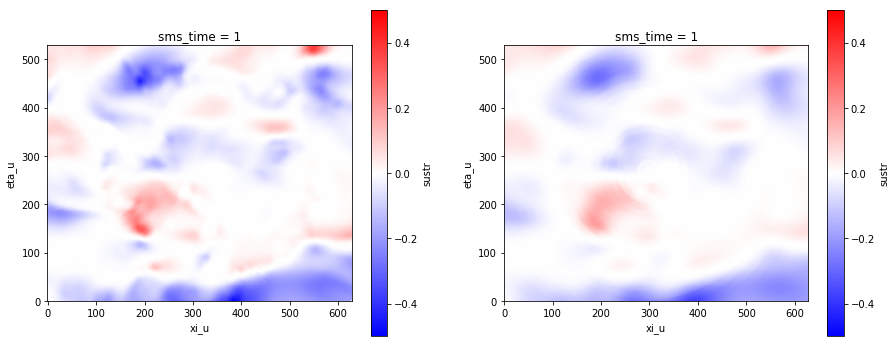

In [54]:
s_min = -0.5
s_max= 0.5
plt.close()
fig,axes = plt.subplots(ncols=2,figsize=(15,6))
ax0,ax1=axes.flatten()
ds.sustr.plot(ax=ax0,vmin=s_min,vmax=s_max,cmap=plt.cm.bwr)
old.sustr[0].plot(ax=ax1,vmin=s_min,vmax=s_max,cmap=plt.cm.bwr)
for ax in axes:
    ax.set_aspect('equal')
plt.show()

<IPython.core.display.Javascript object>


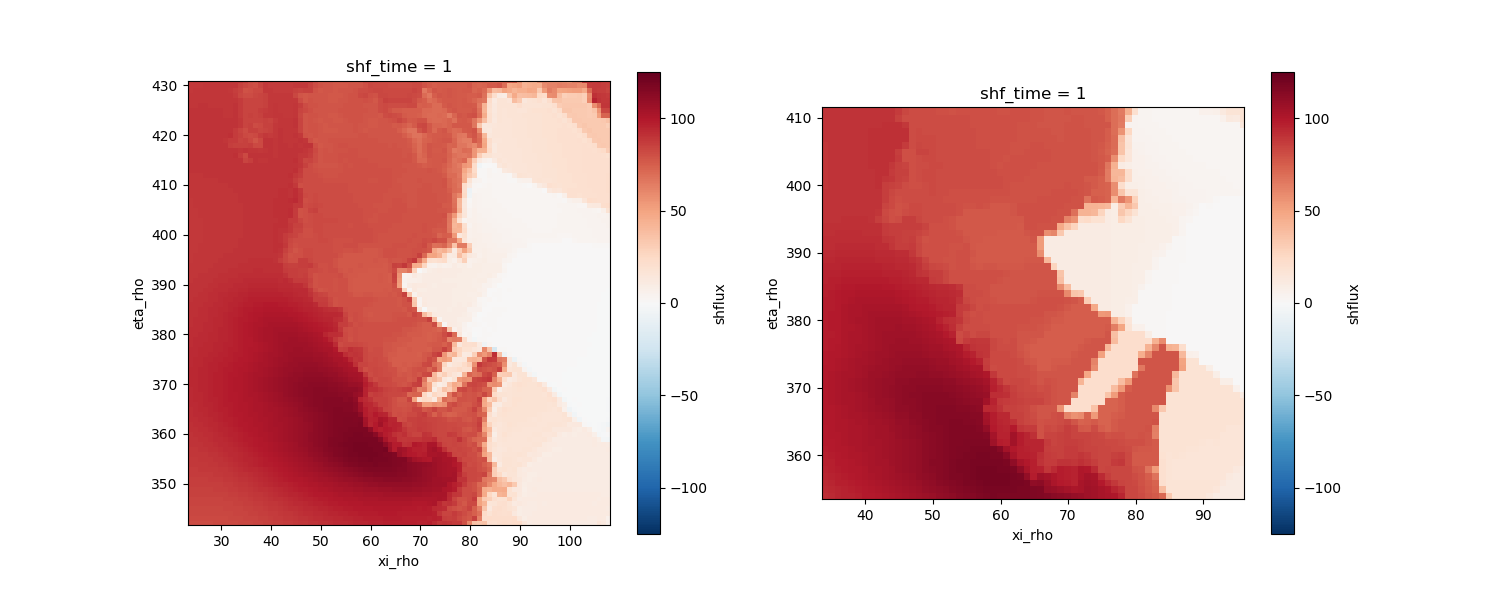

In [58]:
%matplotlib notebook
s_min = -0.5
s_max= 0.5
plt.close()
fig,axes = plt.subplots(ncols=2,figsize=(15,6))
ax0,ax1=axes.flatten()
ds.shflux.plot(ax=ax0)
old_shflx.shflux[0].plot(ax=ax1)
for ax in axes:
    ax.set_aspect('equal')
plt.show()

In [56]:
path = os.path.join(os.environ.get('rawdir'),'gdata','waom_frc','waom10_sustr.nc')
old_sustr = xr.open_dataset(path)

path = os.path.join(os.environ.get('rawdir'),'gdata','waom_frc','waom10_shflux.nc')
old_shflx = xr.open_dataset(path)

In [124]:
for var,dim in zip(['shflux','swflux','sustr','svstr'],['shf_time','swf_time','sms_time','sms_time']):
    ds = xr.open_mfdataset(os.path.join(out_dir,run+'_'+var+'_??.nc'))
    ds[dim]
    ds[dim].attrs['cycle_length'] = float(365)
    out_path = os.path.join(os.environ.get('prodir'),run+'_'+var+'.nc')
    ds.to_netcdf(out_path,'w')